In [1]:
import os
os.chdir('..')
from notebooks import config
import numpy as np
import torch
import time
import random
import glob
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from utils.metric import oa_binary, miou_binary
from utils.imgShow import imsShow
from dataloader.preprocess import read_normalize
from model.seg_model.model_scales_gate import unet_scales_gate
from dataloader.parallel_loader import threads_scene_dset
from dataloader.loader import patch_tensor_dset


In [2]:
# ----------- Device --------------- #
device = torch.device('cuda:1')

# ---------- setting ------- #
torch.manual_seed(999)   # make the trianing replicable


In [3]:
# ---------- Data paths ----------- #
paths_as = sorted(glob.glob(config.dir_as + '/*pad*.tif'))
paths_des = sorted(glob.glob(config.dir_des+'/*pad*.tif'))
paths_truth = sorted(glob.glob(config.dir_truth+'/*pad*.tif'))
paths_patch_val = sorted(glob.glob(config.dir_patch_val+'/*'))
print(len(paths_as))
print(paths_as[0])


23
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_ascend/s1as_scene01_pad.tif


In [4]:
'''--------- data loading --------'''
### ------ 1. training data loading: from scenes path ----- ### 
scene_list, truth_list = read_normalize(paths_as=paths_as, paths_des=paths_des, \
                      paths_truth=paths_truth, max_bands=config.s1_max, min_bands=config.s1_min)
### !!!!extract either ascending or descending image.
# scene_list = [s[2:4] for s in scene_list]    ## [0:2] -> ascending; [2:4] -> descending

tra_dset = threads_scene_dset(scene_list = scene_list[7:23], \
                              truth_list = truth_list[7:23], 
                              transforms=config.transforms_tra, 
                              num_thread=30)

### ----- 2. val data loading: from prepared validation patches ------ ###
patch_list_val = [torch.load(path) for path in paths_patch_val]
# !!!extract either ascending or descending image for validation
# for i in range(len(patch_list_val)):
#    for j in range(len(patch_list_val[0][0])):
#       patch_list_val[i][0][j] = patch_list_val[i][0][j][2:4]   ## [0:2] -> ascending; [2:4] -> descending
#      # patch_list_val[i][0][j][0:2] = 0   ## [0:2] is ascending; and [2:4] is descending

val_dset = patch_tensor_dset(patch_pair_list = patch_list_val)

### ------- print ------- ###
print('size of training data:', tra_dset.__len__())
print('size of val data:', val_dset.__len__())



size of training data: 480
size of val data: 350


In [5]:
tra_loader = torch.utils.data.DataLoader(tra_dset, \
                                batch_size=config.batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dset, batch_size=16)


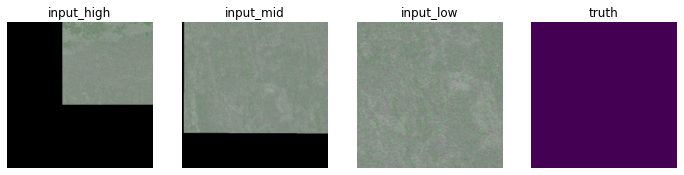

In [6]:
## check training data
for patches, truth in tra_loader:
    patches = patches
    break

patches_ = [patch.to('cpu').detach().numpy().transpose(0,2,3,1).astype(np.float32) for patch in patches]
patches_[0].shape
patches_list = [patches_[0][0],patches_[1][0],patches_[2][0], truth[0].numpy().transpose(1,2,0)]
patches_name = ['input_high','input_mid','input_low','truth']
clip_list = [0,0,0,0]
col_bands_list = [(0,1,0), (0,1,0), (0,1,0), (0,0,0)]
plt.figure(figsize=(12,4))
imsShow(img_list=patches_list, img_name_list=patches_name, \
                                clip_list=clip_list, color_bands_list=col_bands_list)


In [7]:
## ------------ Model ------------ ##
## -------- 3. gated multiple scales -------
model = unet_scales_gate(num_bands=4, num_classes=2, \
                    scale_high=2048, scale_mid=512, scale_low=256).to(device)


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,\
                                          mode='min', factor=0.5, patience=10)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [9]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred,_,_ = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred,_,_ = model(x)
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------ train loops ------'''
def train_loops(model, loss_fn, optimizer, tra_loader, val_loader, epoches, lr_scheduler):
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    tra_loss_loops, tra_miou_loops = [], []
    val_loss_loops, val_miou_loops = [], []
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0

        '''----- 1. train the model -----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = [batch.to(device) for batch in x_batch], y_batch.to(device)
            # x_batch = x_batch[2]      # !!!note: x_batch[2] for single-scale model
            y_batch = config.label_smooth(y_batch)
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                        optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        lr_scheduler.step(tra_loss)         # dynamic adjust learning rate using ReduceLROnPlateau
        # lr_scheduler.step()                 # dynamic adjust learning rate using StepLR

        '''----- 2. validate the model -----'''
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = [batch.to(device).to(dtype=torch.float32) for batch in x_batch], y_batch.to(device)    
            # x_batch = x_batch[2]          #!!!note: x_batch[2] for single-scale model
            loss, miou, oa = val_step(model=model, loss_fn=loss_fn, 
                                                    x=x_batch, y=y_batch)
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()

        '''------ 3. print accuracy ------'''
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        tra_loss_loops.append(tra_loss), tra_miou_loops.append(tra_miou)
        val_loss_loops.append(val_loss), val_miou_loops.append(val_miou)

        format = 'Ep{}: Tra-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f}, Val-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f},Time:{:.1f}s'
        print(format.format(epoch+1, tra_loss, tra_oa, tra_miou, val_loss, val_oa, val_miou, time.time()-start))

        '''------- 4. visualize the result -------'''
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(val_dset))
            patches, truth = val_dset[sam_index]
            patches = [torch.unsqueeze(patch, 0).to(device).to(dtype=torch.float32) for patch in patches]
            truth = truth.to(device)
            # pred = model(patches[2])           # !!! note: x[2] for single-scale model
            pred, gate_mid, gate_high = model(patches)            
            patches = [patch[0].to('cpu').detach().numpy().transpose(1,2,0) for patch in patches]
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            # gate_mid = gate_mid.to('cpu').detach().numpy()
            # gate_high = gate_high.to('cpu').detach().numpy()
            pred = np.where(pred>0.5, 1, 0)
            patches_list = patches + [truth, pred]
            # patches_list = patches + [gate_high[0][0], gate_mid[0][0]] + [truth, pred]
            # ---- plot result
            # print(f'gate_mid:{gate_mid[0,0,0,0]:.2f}, gate_high:{gate_high[0,0,0,0]:.2f}')
            plt.figure(figsize=(14,4))
            # patches_name = ['input_high','input_mid','input_low','gate_high','gate_mid','truth','pred']
            patches_name = ['input_high','input_mid','input_low','truth','pred']
            clip_list = [2,2,2,0,0]
            col_bands_list = [(0,1,0), (0,1,0), (0,1,0), (0,0,0), (0,0,0)]
            imsShow(img_list=patches_list, img_name_list=patches_name, \
                                clip_list=clip_list, color_bands_list=col_bands_list)
            plt.show()

    metrics = {'tra_loss':tra_loss_loops, 'tra_miou':tra_miou_loops, 'val_loss': val_loss_loops, 'val_miou': val_miou_loops}
    return metrics
    

Ep1: Tra-> Loss:0.558,Oa:0.750,Miou:0.642, Val-> Loss:0.448,Oa:0.912,Miou:0.509,Time:7.0s
Ep2: Tra-> Loss:0.448,Oa:0.815,Miou:0.659, Val-> Loss:0.251,Oa:0.938,Miou:0.730,Time:7.4s
Ep3: Tra-> Loss:0.411,Oa:0.884,Miou:0.771, Val-> Loss:0.368,Oa:0.911,Miou:0.490,Time:7.2s
Ep4: Tra-> Loss:0.421,Oa:0.874,Miou:0.722, Val-> Loss:0.236,Oa:0.920,Miou:0.870,Time:6.9s
Ep5: Tra-> Loss:0.430,Oa:0.840,Miou:0.731, Val-> Loss:0.246,Oa:0.941,Miou:0.750,Time:6.6s
Ep6: Tra-> Loss:0.407,Oa:0.874,Miou:0.762, Val-> Loss:0.250,Oa:0.948,Miou:0.769,Time:6.5s
Ep7: Tra-> Loss:0.416,Oa:0.860,Miou:0.752, Val-> Loss:0.229,Oa:0.944,Miou:0.843,Time:7.2s
Ep8: Tra-> Loss:0.413,Oa:0.895,Miou:0.780, Val-> Loss:0.263,Oa:0.948,Miou:0.787,Time:7.1s
Ep9: Tra-> Loss:0.403,Oa:0.879,Miou:0.803, Val-> Loss:0.204,Oa:0.937,Miou:0.842,Time:6.9s
Ep10: Tra-> Loss:0.393,Oa:0.900,Miou:0.807, Val-> Loss:0.230,Oa:0.929,Miou:0.847,Time:7.1s


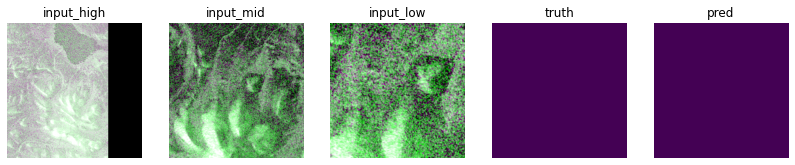

Ep11: Tra-> Loss:0.406,Oa:0.851,Miou:0.767, Val-> Loss:0.319,Oa:0.935,Miou:0.644,Time:6.6s
Ep12: Tra-> Loss:0.395,Oa:0.888,Miou:0.811, Val-> Loss:0.220,Oa:0.942,Miou:0.826,Time:6.9s
Ep13: Tra-> Loss:0.385,Oa:0.905,Miou:0.825, Val-> Loss:0.208,Oa:0.945,Miou:0.825,Time:7.0s
Ep14: Tra-> Loss:0.409,Oa:0.860,Miou:0.745, Val-> Loss:0.240,Oa:0.914,Miou:0.855,Time:7.1s
Ep15: Tra-> Loss:0.393,Oa:0.917,Miou:0.824, Val-> Loss:0.199,Oa:0.942,Miou:0.851,Time:7.4s
Ep16: Tra-> Loss:0.411,Oa:0.883,Miou:0.780, Val-> Loss:0.198,Oa:0.937,Miou:0.867,Time:7.2s
Ep17: Tra-> Loss:0.395,Oa:0.898,Miou:0.793, Val-> Loss:0.210,Oa:0.955,Miou:0.833,Time:7.0s
Ep18: Tra-> Loss:0.389,Oa:0.885,Miou:0.800, Val-> Loss:0.195,Oa:0.944,Miou:0.871,Time:6.7s
Ep19: Tra-> Loss:0.381,Oa:0.903,Miou:0.843, Val-> Loss:0.214,Oa:0.957,Miou:0.828,Time:6.9s
Ep20: Tra-> Loss:0.391,Oa:0.912,Miou:0.832, Val-> Loss:0.212,Oa:0.931,Miou:0.866,Time:7.0s


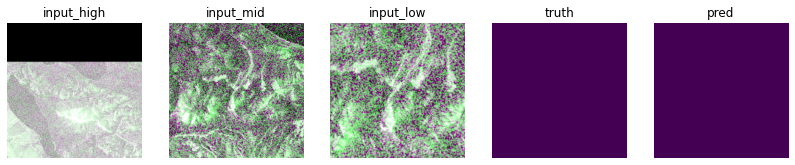

Ep21: Tra-> Loss:0.393,Oa:0.899,Miou:0.819, Val-> Loss:0.290,Oa:0.936,Miou:0.654,Time:6.9s
Ep22: Tra-> Loss:0.394,Oa:0.903,Miou:0.805, Val-> Loss:0.208,Oa:0.909,Miou:0.867,Time:6.8s
Ep23: Tra-> Loss:0.384,Oa:0.893,Miou:0.800, Val-> Loss:0.207,Oa:0.958,Miou:0.787,Time:6.9s
Ep24: Tra-> Loss:0.382,Oa:0.924,Miou:0.833, Val-> Loss:0.266,Oa:0.942,Miou:0.692,Time:6.7s
Ep25: Tra-> Loss:0.381,Oa:0.916,Miou:0.843, Val-> Loss:0.206,Oa:0.959,Miou:0.809,Time:7.2s
Ep26: Tra-> Loss:0.370,Oa:0.919,Miou:0.865, Val-> Loss:0.192,Oa:0.963,Miou:0.849,Time:6.9s
Ep27: Tra-> Loss:0.371,Oa:0.913,Miou:0.847, Val-> Loss:0.210,Oa:0.955,Miou:0.833,Time:7.2s
Ep28: Tra-> Loss:0.383,Oa:0.905,Miou:0.829, Val-> Loss:0.199,Oa:0.944,Miou:0.890,Time:6.6s
Ep29: Tra-> Loss:0.383,Oa:0.906,Miou:0.823, Val-> Loss:0.245,Oa:0.950,Miou:0.772,Time:7.1s
Ep30: Tra-> Loss:0.383,Oa:0.902,Miou:0.822, Val-> Loss:0.238,Oa:0.949,Miou:0.792,Time:7.1s


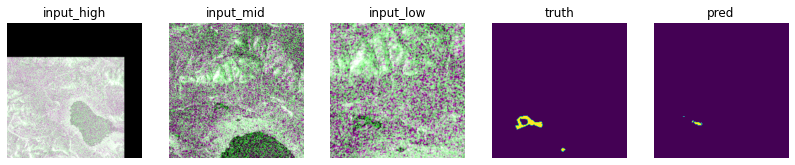

Ep31: Tra-> Loss:0.378,Oa:0.904,Miou:0.836, Val-> Loss:0.208,Oa:0.904,Miou:0.865,Time:6.7s
Ep32: Tra-> Loss:0.404,Oa:0.885,Miou:0.801, Val-> Loss:0.310,Oa:0.931,Miou:0.653,Time:7.2s
Ep33: Tra-> Loss:0.380,Oa:0.924,Miou:0.844, Val-> Loss:0.318,Oa:0.935,Miou:0.669,Time:6.7s
Ep34: Tra-> Loss:0.369,Oa:0.935,Miou:0.880, Val-> Loss:0.191,Oa:0.968,Miou:0.897,Time:7.0s
Ep35: Tra-> Loss:0.359,Oa:0.953,Miou:0.918, Val-> Loss:0.167,Oa:0.961,Miou:0.912,Time:6.9s
Ep36: Tra-> Loss:0.371,Oa:0.947,Miou:0.877, Val-> Loss:0.184,Oa:0.945,Miou:0.911,Time:7.0s
Ep37: Tra-> Loss:0.385,Oa:0.910,Miou:0.844, Val-> Loss:0.219,Oa:0.957,Miou:0.769,Time:6.8s
Ep38: Tra-> Loss:0.367,Oa:0.947,Miou:0.863, Val-> Loss:0.183,Oa:0.959,Miou:0.903,Time:6.8s
Ep39: Tra-> Loss:0.363,Oa:0.951,Miou:0.894, Val-> Loss:0.184,Oa:0.937,Miou:0.905,Time:7.1s
Ep40: Tra-> Loss:0.367,Oa:0.948,Miou:0.860, Val-> Loss:0.185,Oa:0.973,Miou:0.898,Time:6.6s


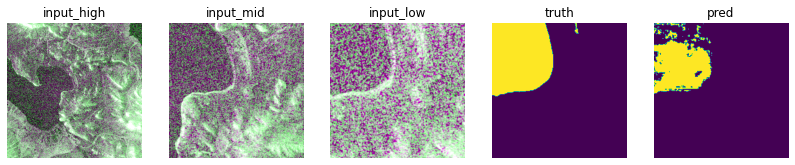

Ep41: Tra-> Loss:0.359,Oa:0.946,Miou:0.904, Val-> Loss:0.294,Oa:0.944,Miou:0.695,Time:6.7s
Ep42: Tra-> Loss:0.367,Oa:0.948,Miou:0.893, Val-> Loss:0.185,Oa:0.972,Miou:0.866,Time:7.1s
Ep43: Tra-> Loss:0.366,Oa:0.941,Miou:0.871, Val-> Loss:0.176,Oa:0.967,Miou:0.905,Time:6.8s
Ep44: Tra-> Loss:0.366,Oa:0.926,Miou:0.860, Val-> Loss:0.175,Oa:0.974,Miou:0.893,Time:7.0s
Ep45: Tra-> Loss:0.359,Oa:0.961,Miou:0.911, Val-> Loss:0.168,Oa:0.962,Miou:0.909,Time:6.8s
Ep46: Tra-> Loss:0.369,Oa:0.945,Miou:0.893, Val-> Loss:0.171,Oa:0.974,Miou:0.887,Time:6.9s
Ep47: Tra-> Loss:0.369,Oa:0.925,Miou:0.858, Val-> Loss:0.181,Oa:0.970,Miou:0.882,Time:7.0s
Ep48: Tra-> Loss:0.361,Oa:0.941,Miou:0.888, Val-> Loss:0.239,Oa:0.961,Miou:0.801,Time:7.1s
Ep49: Tra-> Loss:0.366,Oa:0.954,Miou:0.887, Val-> Loss:0.171,Oa:0.971,Miou:0.913,Time:7.2s
Ep50: Tra-> Loss:0.355,Oa:0.964,Miou:0.926, Val-> Loss:0.177,Oa:0.972,Miou:0.904,Time:6.9s


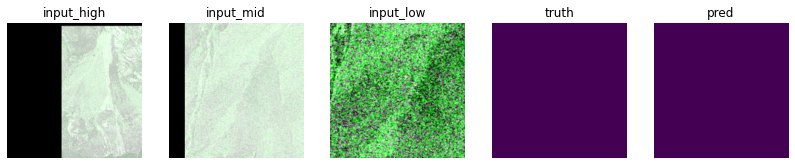

Ep51: Tra-> Loss:0.364,Oa:0.936,Miou:0.881, Val-> Loss:0.200,Oa:0.965,Miou:0.836,Time:7.3s
Ep52: Tra-> Loss:0.367,Oa:0.948,Miou:0.880, Val-> Loss:0.234,Oa:0.958,Miou:0.784,Time:7.1s
Ep53: Tra-> Loss:0.359,Oa:0.935,Miou:0.877, Val-> Loss:0.199,Oa:0.962,Miou:0.832,Time:6.9s
Ep54: Tra-> Loss:0.360,Oa:0.955,Miou:0.898, Val-> Loss:0.150,Oa:0.971,Miou:0.935,Time:7.3s
Ep55: Tra-> Loss:0.350,Oa:0.952,Miou:0.908, Val-> Loss:0.166,Oa:0.975,Miou:0.901,Time:7.0s
Ep56: Tra-> Loss:0.357,Oa:0.956,Miou:0.906, Val-> Loss:0.199,Oa:0.966,Miou:0.820,Time:6.9s
Ep57: Tra-> Loss:0.355,Oa:0.963,Miou:0.911, Val-> Loss:0.151,Oa:0.967,Miou:0.929,Time:7.0s
Ep58: Tra-> Loss:0.351,Oa:0.947,Miou:0.907, Val-> Loss:0.165,Oa:0.974,Miou:0.906,Time:7.1s
Ep59: Tra-> Loss:0.353,Oa:0.923,Miou:0.881, Val-> Loss:0.167,Oa:0.967,Miou:0.922,Time:6.9s
Ep60: Tra-> Loss:0.350,Oa:0.943,Miou:0.907, Val-> Loss:0.146,Oa:0.966,Miou:0.934,Time:6.8s


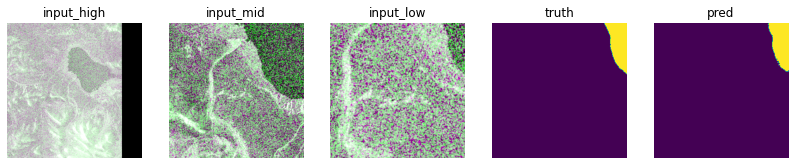

Ep61: Tra-> Loss:0.347,Oa:0.963,Miou:0.924, Val-> Loss:0.158,Oa:0.977,Miou:0.917,Time:7.0s
Ep62: Tra-> Loss:0.357,Oa:0.948,Miou:0.905, Val-> Loss:0.166,Oa:0.964,Miou:0.917,Time:7.3s
Ep63: Tra-> Loss:0.350,Oa:0.967,Miou:0.927, Val-> Loss:0.162,Oa:0.970,Miou:0.912,Time:6.7s
Ep64: Tra-> Loss:0.360,Oa:0.943,Miou:0.888, Val-> Loss:0.155,Oa:0.969,Miou:0.935,Time:7.0s
Ep65: Tra-> Loss:0.355,Oa:0.956,Miou:0.907, Val-> Loss:0.158,Oa:0.969,Miou:0.927,Time:6.8s
Ep66: Tra-> Loss:0.356,Oa:0.966,Miou:0.924, Val-> Loss:0.177,Oa:0.976,Miou:0.875,Time:7.2s
Ep67: Tra-> Loss:0.360,Oa:0.944,Miou:0.878, Val-> Loss:0.184,Oa:0.973,Miou:0.899,Time:7.2s
Ep68: Tra-> Loss:0.355,Oa:0.952,Miou:0.906, Val-> Loss:0.165,Oa:0.971,Miou:0.913,Time:7.0s
Ep69: Tra-> Loss:0.363,Oa:0.935,Miou:0.868, Val-> Loss:0.159,Oa:0.974,Miou:0.919,Time:7.0s
Ep70: Tra-> Loss:0.354,Oa:0.961,Miou:0.917, Val-> Loss:0.157,Oa:0.960,Miou:0.908,Time:7.2s


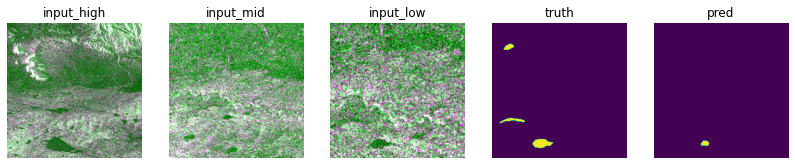

Ep71: Tra-> Loss:0.354,Oa:0.953,Miou:0.907, Val-> Loss:0.171,Oa:0.969,Miou:0.890,Time:7.0s
Ep72: Tra-> Loss:0.361,Oa:0.930,Miou:0.883, Val-> Loss:0.167,Oa:0.967,Miou:0.906,Time:7.3s
Ep73: Tra-> Loss:0.358,Oa:0.953,Miou:0.903, Val-> Loss:0.161,Oa:0.978,Miou:0.911,Time:6.9s
Ep74: Tra-> Loss:0.349,Oa:0.966,Miou:0.926, Val-> Loss:0.156,Oa:0.979,Miou:0.930,Time:7.4s
Ep75: Tra-> Loss:0.346,Oa:0.972,Miou:0.937, Val-> Loss:0.159,Oa:0.980,Miou:0.918,Time:6.7s
Ep76: Tra-> Loss:0.343,Oa:0.974,Miou:0.945, Val-> Loss:0.151,Oa:0.979,Miou:0.920,Time:6.7s
Ep77: Tra-> Loss:0.346,Oa:0.964,Miou:0.924, Val-> Loss:0.150,Oa:0.977,Miou:0.928,Time:7.1s
Ep78: Tra-> Loss:0.353,Oa:0.966,Miou:0.923, Val-> Loss:0.155,Oa:0.972,Miou:0.931,Time:7.1s
Ep79: Tra-> Loss:0.350,Oa:0.970,Miou:0.921, Val-> Loss:0.150,Oa:0.975,Miou:0.922,Time:6.9s
Ep80: Tra-> Loss:0.342,Oa:0.978,Miou:0.950, Val-> Loss:0.148,Oa:0.978,Miou:0.927,Time:7.1s


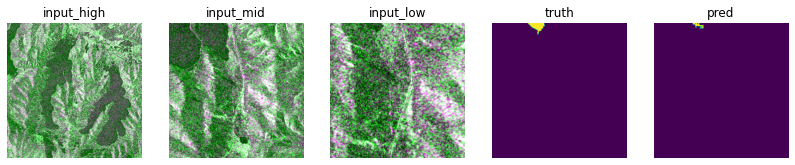

Ep81: Tra-> Loss:0.357,Oa:0.950,Miou:0.903, Val-> Loss:0.159,Oa:0.980,Miou:0.924,Time:7.1s
Ep82: Tra-> Loss:0.357,Oa:0.961,Miou:0.914, Val-> Loss:0.166,Oa:0.976,Miou:0.917,Time:6.9s
Ep83: Tra-> Loss:0.343,Oa:0.978,Miou:0.955, Val-> Loss:0.160,Oa:0.969,Miou:0.920,Time:7.1s
Ep84: Tra-> Loss:0.348,Oa:0.952,Miou:0.919, Val-> Loss:0.158,Oa:0.976,Miou:0.920,Time:7.1s
Ep85: Tra-> Loss:0.337,Oa:0.980,Miou:0.951, Val-> Loss:0.186,Oa:0.973,Miou:0.873,Time:7.0s
Ep86: Tra-> Loss:0.342,Oa:0.961,Miou:0.935, Val-> Loss:0.162,Oa:0.975,Miou:0.916,Time:7.2s
Ep87: Tra-> Loss:0.349,Oa:0.962,Miou:0.929, Val-> Loss:0.175,Oa:0.976,Miou:0.897,Time:6.8s
Ep88: Tra-> Loss:0.350,Oa:0.952,Miou:0.920, Val-> Loss:0.201,Oa:0.965,Miou:0.847,Time:7.5s
Ep89: Tra-> Loss:0.342,Oa:0.981,Miou:0.954, Val-> Loss:0.155,Oa:0.973,Miou:0.923,Time:6.6s
Ep90: Tra-> Loss:0.348,Oa:0.960,Miou:0.908, Val-> Loss:0.178,Oa:0.976,Miou:0.897,Time:6.9s


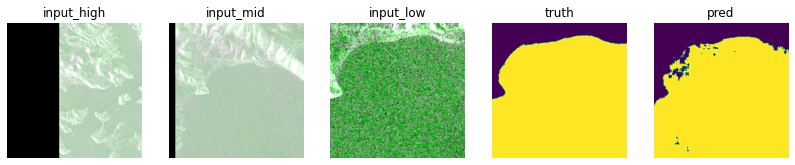

Ep91: Tra-> Loss:0.348,Oa:0.963,Miou:0.929, Val-> Loss:0.158,Oa:0.973,Miou:0.930,Time:6.7s
Ep92: Tra-> Loss:0.347,Oa:0.964,Miou:0.929, Val-> Loss:0.152,Oa:0.979,Miou:0.927,Time:7.1s
Ep93: Tra-> Loss:0.350,Oa:0.968,Miou:0.920, Val-> Loss:0.169,Oa:0.975,Miou:0.909,Time:6.8s
Ep94: Tra-> Loss:0.354,Oa:0.958,Miou:0.912, Val-> Loss:0.156,Oa:0.975,Miou:0.938,Time:6.8s
Ep95: Tra-> Loss:0.346,Oa:0.958,Miou:0.917, Val-> Loss:0.160,Oa:0.975,Miou:0.922,Time:7.0s
Ep96: Tra-> Loss:0.335,Oa:0.984,Miou:0.964, Val-> Loss:0.153,Oa:0.978,Miou:0.924,Time:6.9s
Ep97: Tra-> Loss:0.342,Oa:0.976,Miou:0.948, Val-> Loss:0.150,Oa:0.979,Miou:0.929,Time:6.7s
Ep98: Tra-> Loss:0.341,Oa:0.970,Miou:0.940, Val-> Loss:0.170,Oa:0.975,Miou:0.897,Time:7.5s
Ep99: Tra-> Loss:0.341,Oa:0.981,Miou:0.951, Val-> Loss:0.147,Oa:0.976,Miou:0.930,Time:7.1s
Ep100: Tra-> Loss:0.339,Oa:0.971,Miou:0.946, Val-> Loss:0.155,Oa:0.973,Miou:0.909,Time:6.7s


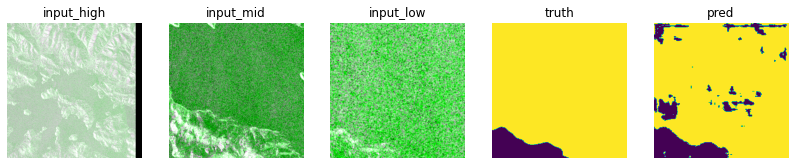

Ep101: Tra-> Loss:0.341,Oa:0.969,Miou:0.937, Val-> Loss:0.249,Oa:0.953,Miou:0.768,Time:7.4s
Ep102: Tra-> Loss:0.350,Oa:0.959,Miou:0.918, Val-> Loss:0.215,Oa:0.964,Miou:0.821,Time:6.8s
Ep103: Tra-> Loss:0.342,Oa:0.964,Miou:0.932, Val-> Loss:0.151,Oa:0.978,Miou:0.920,Time:6.7s
Ep104: Tra-> Loss:0.339,Oa:0.967,Miou:0.943, Val-> Loss:0.149,Oa:0.977,Miou:0.928,Time:7.3s
Ep105: Tra-> Loss:0.339,Oa:0.952,Miou:0.920, Val-> Loss:0.156,Oa:0.980,Miou:0.907,Time:7.3s
Ep106: Tra-> Loss:0.342,Oa:0.978,Miou:0.953, Val-> Loss:0.155,Oa:0.978,Miou:0.920,Time:7.1s
Ep107: Tra-> Loss:0.348,Oa:0.963,Miou:0.925, Val-> Loss:0.146,Oa:0.978,Miou:0.937,Time:7.1s
Ep108: Tra-> Loss:0.344,Oa:0.973,Miou:0.944, Val-> Loss:0.149,Oa:0.979,Miou:0.933,Time:6.7s
Ep109: Tra-> Loss:0.339,Oa:0.966,Miou:0.936, Val-> Loss:0.146,Oa:0.982,Miou:0.932,Time:6.9s
Ep110: Tra-> Loss:0.342,Oa:0.968,Miou:0.941, Val-> Loss:0.149,Oa:0.980,Miou:0.934,Time:6.8s


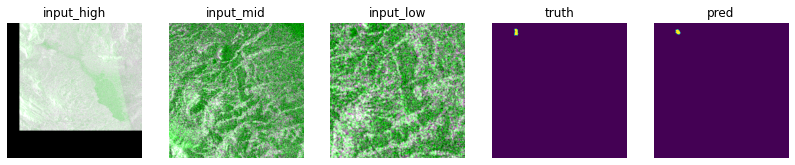

Ep111: Tra-> Loss:0.352,Oa:0.960,Miou:0.913, Val-> Loss:0.153,Oa:0.981,Miou:0.922,Time:7.3s
Ep112: Tra-> Loss:0.346,Oa:0.958,Miou:0.920, Val-> Loss:0.142,Oa:0.980,Miou:0.948,Time:7.1s
Ep113: Tra-> Loss:0.346,Oa:0.957,Miou:0.916, Val-> Loss:0.149,Oa:0.979,Miou:0.936,Time:7.3s
Ep114: Tra-> Loss:0.341,Oa:0.968,Miou:0.937, Val-> Loss:0.143,Oa:0.981,Miou:0.940,Time:6.8s
Ep115: Tra-> Loss:0.344,Oa:0.975,Miou:0.942, Val-> Loss:0.146,Oa:0.976,Miou:0.941,Time:7.1s
Ep116: Tra-> Loss:0.343,Oa:0.974,Miou:0.929, Val-> Loss:0.155,Oa:0.976,Miou:0.926,Time:7.1s
Ep117: Tra-> Loss:0.339,Oa:0.974,Miou:0.943, Val-> Loss:0.149,Oa:0.979,Miou:0.925,Time:7.0s
Ep118: Tra-> Loss:0.344,Oa:0.974,Miou:0.941, Val-> Loss:0.147,Oa:0.977,Miou:0.931,Time:7.1s
Ep119: Tra-> Loss:0.340,Oa:0.971,Miou:0.943, Val-> Loss:0.148,Oa:0.975,Miou:0.935,Time:7.0s
Ep120: Tra-> Loss:0.342,Oa:0.976,Miou:0.948, Val-> Loss:0.143,Oa:0.979,Miou:0.940,Time:6.8s


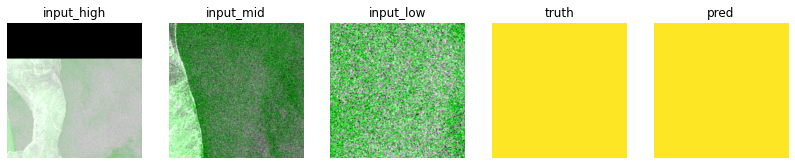

Ep121: Tra-> Loss:0.343,Oa:0.964,Miou:0.932, Val-> Loss:0.151,Oa:0.980,Miou:0.930,Time:6.9s
Ep122: Tra-> Loss:0.341,Oa:0.973,Miou:0.937, Val-> Loss:0.144,Oa:0.979,Miou:0.944,Time:7.2s
Ep123: Tra-> Loss:0.337,Oa:0.983,Miou:0.958, Val-> Loss:0.143,Oa:0.977,Miou:0.941,Time:6.9s
Ep124: Tra-> Loss:0.337,Oa:0.980,Miou:0.951, Val-> Loss:0.144,Oa:0.979,Miou:0.943,Time:6.9s
Ep125: Tra-> Loss:0.342,Oa:0.971,Miou:0.936, Val-> Loss:0.148,Oa:0.981,Miou:0.934,Time:6.9s
Ep126: Tra-> Loss:0.340,Oa:0.979,Miou:0.953, Val-> Loss:0.148,Oa:0.983,Miou:0.931,Time:6.9s
Ep127: Tra-> Loss:0.342,Oa:0.980,Miou:0.950, Val-> Loss:0.153,Oa:0.979,Miou:0.927,Time:7.0s
Ep128: Tra-> Loss:0.348,Oa:0.963,Miou:0.931, Val-> Loss:0.149,Oa:0.977,Miou:0.935,Time:7.1s
Ep129: Tra-> Loss:0.341,Oa:0.974,Miou:0.941, Val-> Loss:0.150,Oa:0.977,Miou:0.935,Time:6.9s
Ep130: Tra-> Loss:0.342,Oa:0.962,Miou:0.935, Val-> Loss:0.148,Oa:0.979,Miou:0.935,Time:7.0s


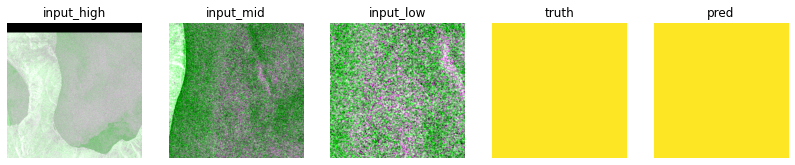

Ep131: Tra-> Loss:0.339,Oa:0.985,Miou:0.959, Val-> Loss:0.147,Oa:0.978,Miou:0.937,Time:6.9s
Ep132: Tra-> Loss:0.338,Oa:0.984,Miou:0.961, Val-> Loss:0.148,Oa:0.977,Miou:0.932,Time:7.3s
Ep133: Tra-> Loss:0.337,Oa:0.985,Miou:0.966, Val-> Loss:0.149,Oa:0.979,Miou:0.928,Time:6.9s
Ep134: Tra-> Loss:0.343,Oa:0.968,Miou:0.937, Val-> Loss:0.148,Oa:0.977,Miou:0.933,Time:6.8s
Ep135: Tra-> Loss:0.341,Oa:0.960,Miou:0.939, Val-> Loss:0.147,Oa:0.978,Miou:0.935,Time:7.0s
Ep136: Tra-> Loss:0.339,Oa:0.983,Miou:0.958, Val-> Loss:0.147,Oa:0.979,Miou:0.933,Time:7.2s
Ep137: Tra-> Loss:0.341,Oa:0.965,Miou:0.928, Val-> Loss:0.148,Oa:0.978,Miou:0.933,Time:7.1s
Ep138: Tra-> Loss:0.341,Oa:0.975,Miou:0.946, Val-> Loss:0.146,Oa:0.978,Miou:0.938,Time:6.8s
Ep139: Tra-> Loss:0.337,Oa:0.972,Miou:0.950, Val-> Loss:0.146,Oa:0.978,Miou:0.935,Time:6.9s
Ep140: Tra-> Loss:0.345,Oa:0.959,Miou:0.918, Val-> Loss:0.155,Oa:0.978,Miou:0.923,Time:6.8s


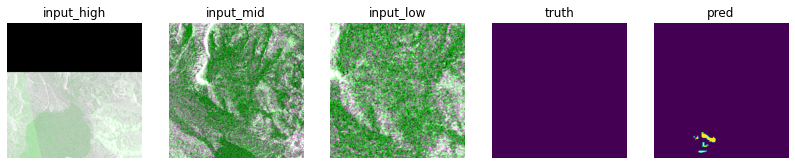

Ep141: Tra-> Loss:0.338,Oa:0.977,Miou:0.942, Val-> Loss:0.153,Oa:0.978,Miou:0.926,Time:6.8s
Ep142: Tra-> Loss:0.343,Oa:0.982,Miou:0.947, Val-> Loss:0.149,Oa:0.977,Miou:0.933,Time:7.1s
Ep143: Tra-> Loss:0.342,Oa:0.946,Miou:0.917, Val-> Loss:0.148,Oa:0.977,Miou:0.935,Time:7.0s
Ep144: Tra-> Loss:0.335,Oa:0.985,Miou:0.968, Val-> Loss:0.147,Oa:0.978,Miou:0.933,Time:7.1s
Ep145: Tra-> Loss:0.335,Oa:0.970,Miou:0.949, Val-> Loss:0.148,Oa:0.979,Miou:0.932,Time:7.0s
Ep146: Tra-> Loss:0.334,Oa:0.981,Miou:0.963, Val-> Loss:0.148,Oa:0.979,Miou:0.931,Time:7.0s
Ep147: Tra-> Loss:0.336,Oa:0.984,Miou:0.961, Val-> Loss:0.147,Oa:0.979,Miou:0.933,Time:6.8s
Ep148: Tra-> Loss:0.337,Oa:0.967,Miou:0.940, Val-> Loss:0.148,Oa:0.979,Miou:0.933,Time:7.1s
Ep149: Tra-> Loss:0.338,Oa:0.968,Miou:0.944, Val-> Loss:0.149,Oa:0.978,Miou:0.930,Time:7.0s
Ep150: Tra-> Loss:0.339,Oa:0.983,Miou:0.960, Val-> Loss:0.151,Oa:0.978,Miou:0.927,Time:6.9s


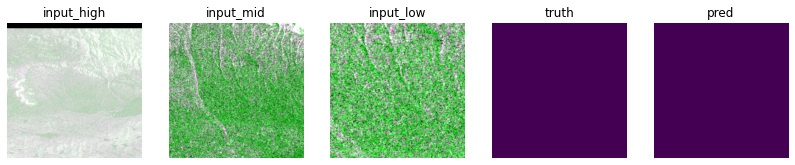

Ep151: Tra-> Loss:0.342,Oa:0.968,Miou:0.939, Val-> Loss:0.150,Oa:0.978,Miou:0.931,Time:7.1s
Ep152: Tra-> Loss:0.341,Oa:0.968,Miou:0.937, Val-> Loss:0.150,Oa:0.979,Miou:0.929,Time:6.7s
Ep153: Tra-> Loss:0.340,Oa:0.981,Miou:0.955, Val-> Loss:0.147,Oa:0.979,Miou:0.938,Time:6.9s
Ep154: Tra-> Loss:0.337,Oa:0.985,Miou:0.959, Val-> Loss:0.146,Oa:0.979,Miou:0.937,Time:6.8s
Ep155: Tra-> Loss:0.338,Oa:0.952,Miou:0.931, Val-> Loss:0.146,Oa:0.979,Miou:0.938,Time:7.0s
Ep156: Tra-> Loss:0.338,Oa:0.983,Miou:0.964, Val-> Loss:0.145,Oa:0.979,Miou:0.938,Time:6.7s
Ep157: Tra-> Loss:0.339,Oa:0.980,Miou:0.957, Val-> Loss:0.146,Oa:0.979,Miou:0.935,Time:6.8s
Ep158: Tra-> Loss:0.337,Oa:0.980,Miou:0.960, Val-> Loss:0.147,Oa:0.979,Miou:0.933,Time:7.1s
Ep159: Tra-> Loss:0.341,Oa:0.976,Miou:0.948, Val-> Loss:0.147,Oa:0.979,Miou:0.933,Time:6.9s
Ep160: Tra-> Loss:0.339,Oa:0.979,Miou:0.952, Val-> Loss:0.147,Oa:0.979,Miou:0.933,Time:7.1s


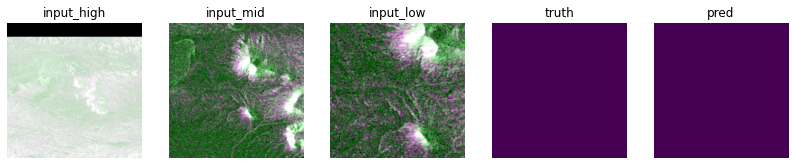

Ep161: Tra-> Loss:0.339,Oa:0.981,Miou:0.958, Val-> Loss:0.147,Oa:0.979,Miou:0.933,Time:7.0s
Ep162: Tra-> Loss:0.341,Oa:0.977,Miou:0.954, Val-> Loss:0.148,Oa:0.980,Miou:0.932,Time:7.0s
Ep163: Tra-> Loss:0.336,Oa:0.970,Miou:0.947, Val-> Loss:0.147,Oa:0.979,Miou:0.933,Time:7.1s
Ep164: Tra-> Loss:0.345,Oa:0.981,Miou:0.947, Val-> Loss:0.147,Oa:0.979,Miou:0.937,Time:6.9s
Ep165: Tra-> Loss:0.340,Oa:0.979,Miou:0.954, Val-> Loss:0.145,Oa:0.980,Miou:0.940,Time:6.8s
Ep166: Tra-> Loss:0.343,Oa:0.976,Miou:0.940, Val-> Loss:0.143,Oa:0.979,Miou:0.942,Time:7.1s
Ep167: Tra-> Loss:0.338,Oa:0.968,Miou:0.939, Val-> Loss:0.143,Oa:0.979,Miou:0.943,Time:7.2s
Ep168: Tra-> Loss:0.336,Oa:0.982,Miou:0.962, Val-> Loss:0.143,Oa:0.980,Miou:0.941,Time:6.8s
Ep169: Tra-> Loss:0.340,Oa:0.981,Miou:0.957, Val-> Loss:0.143,Oa:0.980,Miou:0.941,Time:7.0s
Ep170: Tra-> Loss:0.342,Oa:0.965,Miou:0.938, Val-> Loss:0.144,Oa:0.980,Miou:0.940,Time:6.8s


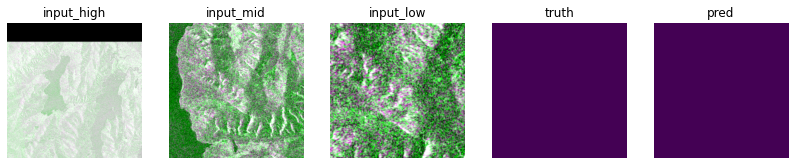

Ep171: Tra-> Loss:0.340,Oa:0.978,Miou:0.952, Val-> Loss:0.144,Oa:0.980,Miou:0.940,Time:6.7s
Ep172: Tra-> Loss:0.341,Oa:0.962,Miou:0.937, Val-> Loss:0.144,Oa:0.980,Miou:0.940,Time:7.0s
Ep173: Tra-> Loss:0.341,Oa:0.965,Miou:0.935, Val-> Loss:0.145,Oa:0.980,Miou:0.939,Time:6.8s
Ep174: Tra-> Loss:0.339,Oa:0.972,Miou:0.946, Val-> Loss:0.145,Oa:0.980,Miou:0.938,Time:7.2s
Ep175: Tra-> Loss:0.340,Oa:0.982,Miou:0.952, Val-> Loss:0.145,Oa:0.980,Miou:0.937,Time:7.0s
Ep176: Tra-> Loss:0.340,Oa:0.972,Miou:0.939, Val-> Loss:0.144,Oa:0.980,Miou:0.940,Time:6.8s
Ep177: Tra-> Loss:0.339,Oa:0.977,Miou:0.948, Val-> Loss:0.145,Oa:0.980,Miou:0.939,Time:7.0s
Ep178: Tra-> Loss:0.337,Oa:0.960,Miou:0.929, Val-> Loss:0.145,Oa:0.980,Miou:0.938,Time:6.6s
Ep179: Tra-> Loss:0.342,Oa:0.971,Miou:0.942, Val-> Loss:0.145,Oa:0.980,Miou:0.938,Time:7.0s
Ep180: Tra-> Loss:0.340,Oa:0.978,Miou:0.954, Val-> Loss:0.144,Oa:0.980,Miou:0.939,Time:6.8s


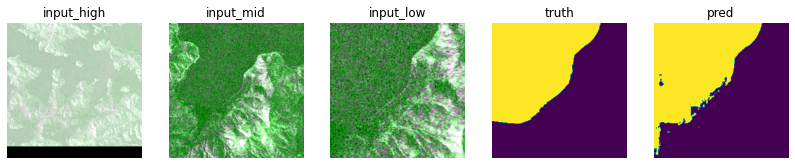

Ep181: Tra-> Loss:0.340,Oa:0.966,Miou:0.943, Val-> Loss:0.144,Oa:0.980,Miou:0.940,Time:7.1s
Ep182: Tra-> Loss:0.337,Oa:0.978,Miou:0.951, Val-> Loss:0.145,Oa:0.980,Miou:0.939,Time:6.8s
Ep183: Tra-> Loss:0.339,Oa:0.986,Miou:0.956, Val-> Loss:0.145,Oa:0.980,Miou:0.939,Time:6.7s
Ep184: Tra-> Loss:0.343,Oa:0.965,Miou:0.926, Val-> Loss:0.144,Oa:0.980,Miou:0.940,Time:7.0s
Ep185: Tra-> Loss:0.339,Oa:0.982,Miou:0.958, Val-> Loss:0.144,Oa:0.980,Miou:0.940,Time:6.9s
Ep186: Tra-> Loss:0.339,Oa:0.981,Miou:0.958, Val-> Loss:0.145,Oa:0.980,Miou:0.939,Time:7.4s
Ep187: Tra-> Loss:0.337,Oa:0.980,Miou:0.963, Val-> Loss:0.145,Oa:0.980,Miou:0.939,Time:6.9s
Ep188: Tra-> Loss:0.339,Oa:0.972,Miou:0.953, Val-> Loss:0.145,Oa:0.980,Miou:0.938,Time:6.6s
Ep189: Tra-> Loss:0.337,Oa:0.976,Miou:0.946, Val-> Loss:0.145,Oa:0.980,Miou:0.937,Time:6.9s
Ep190: Tra-> Loss:0.337,Oa:0.977,Miou:0.954, Val-> Loss:0.145,Oa:0.980,Miou:0.937,Time:7.0s


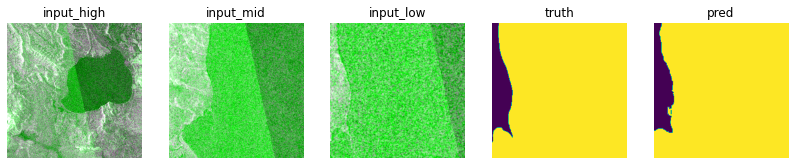

Ep191: Tra-> Loss:0.338,Oa:0.985,Miou:0.959, Val-> Loss:0.145,Oa:0.980,Miou:0.937,Time:6.8s
Ep192: Tra-> Loss:0.335,Oa:0.972,Miou:0.944, Val-> Loss:0.145,Oa:0.980,Miou:0.937,Time:7.4s
Ep193: Tra-> Loss:0.336,Oa:0.980,Miou:0.959, Val-> Loss:0.145,Oa:0.980,Miou:0.937,Time:6.9s
Ep194: Tra-> Loss:0.341,Oa:0.981,Miou:0.946, Val-> Loss:0.145,Oa:0.980,Miou:0.938,Time:7.1s
Ep195: Tra-> Loss:0.338,Oa:0.972,Miou:0.944, Val-> Loss:0.145,Oa:0.980,Miou:0.938,Time:6.8s
Ep196: Tra-> Loss:0.344,Oa:0.975,Miou:0.942, Val-> Loss:0.145,Oa:0.980,Miou:0.939,Time:6.7s
Ep197: Tra-> Loss:0.346,Oa:0.954,Miou:0.925, Val-> Loss:0.145,Oa:0.980,Miou:0.938,Time:7.0s
Ep198: Tra-> Loss:0.338,Oa:0.986,Miou:0.963, Val-> Loss:0.145,Oa:0.980,Miou:0.938,Time:6.9s
Ep199: Tra-> Loss:0.341,Oa:0.978,Miou:0.950, Val-> Loss:0.145,Oa:0.980,Miou:0.938,Time:6.9s
Ep200: Tra-> Loss:0.339,Oa:0.973,Miou:0.944, Val-> Loss:0.145,Oa:0.980,Miou:0.938,Time:6.9s


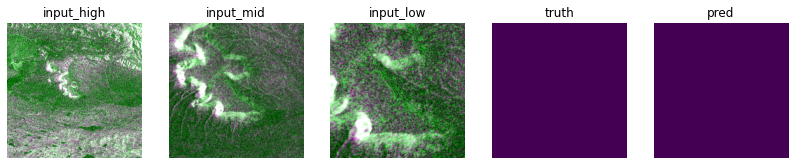

In [10]:
metrics = train_loops(model=model,  
                      loss_fn=config.loss_bce,  
                      optimizer=optimizer,  
                      tra_loader=tra_loader,  
                      val_loader=val_loader,  
                      epoches=config.epoch,  
                      lr_scheduler=lr_scheduler)


## Model and metrics saving


In [11]:
# # model_name = 'gscales_des_test_13'
# model_name = 'model_gscales_test_8'
# # model save/load
# # path_weights = config.root_proj + '/model/pretrained/gscales_as_test/' + model_name + '_weights.pth'
# path_weights = config.root_proj + '/model/pretrained/model_gscales_test/' + model_name + '_weights.pth'
# torch.save(model.state_dict(), path_weights)
# # model.load_state_dict(torch.load(path_weights))


In [12]:
# ## metrics saving
# # path_metrics = config.root_proj + '/model/pretrained/gscales_des_test/' + model_name + '_metrics.csv'
# path_metrics = config.root_proj + '/model/pretrained/model_gscales_test/' + model_name + '_metrics.csv'
# metrics_df = pd.DataFrame(metrics)
# metrics_df.to_csv(path_metrics, index=False, sep=',')
# metrics_df = pd.read_csv(path_metrics)
